In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
import pandas as pd
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
import pandas as pd
# Lire le fichier sans spécifier de noms de colonnes
df = pd.read_csv("../data/training.1600000.processed.noemoticon.csv", encoding="latin-1", names=colonnes)

# Afficher les 5 premières lignes
print(df.head())


   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [17]:
 # Garder les colonnes par position (0 = sentiment, 5 = texte)
df = df.iloc[:, [0, 5]]

# Renommer les colonnes pour plus de clarté
df.columns = ['sentiment', 'text']

# Afficher les 5 premières lignes
print(df.head())


   sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....


In [18]:
df.duplicated().sum()


np.int64(16309)

In [20]:
df.drop_duplicates(inplace=True)


C:\Users\ilyas\AppData\Local\Temp\ipykernel_10932\3617111529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [21]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1583691 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1583691 non-null  int64 
 1   text       1583691 non-null  object
dtypes: int64(1), object(1)
memory usage: 36.2+ MB


In [22]:
df.describe()


,sentiment
count,1.583691e+06
mean,2.004194e+00
std,1.999996e+00
min,0.000000e+00
25%,0.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,4.000000e+00


In [23]:
df.isna().sum()


sentiment    0
text         0
dtype: int64

In [ ]:
# Mapping des sentiments
df['sentiment'] = df['sentiment'].map({0: 'negatif', 4: 'positif'})


sentiment
positif    793506
negatif    790185
Name: count, dtype: int64


C:\Users\ilyas\AppData\Local\Temp\ipykernel_10932\2801768189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].map({0: 'negatif', 4: 'positif'})


In [28]:
df.sentiment.value_counts()


sentiment
positif    793506
negatif    790185
Name: count, dtype: int64

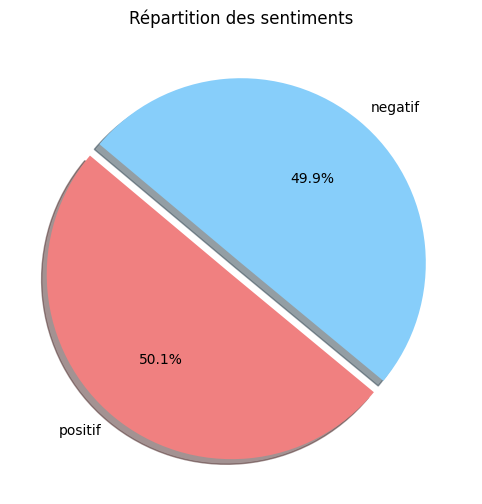

In [29]:
import matplotlib.pyplot as plt

# Si tu veux des couleurs custom, par exemple :
colors = ['lightcoral', 'lightskyblue']

# Plot pie chart
df["sentiment"].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(8, 6),
    explode=(0.08, 0),  # un peu d'explosion sur la première part
    shadow=True,
    colors=colors,
    startangle=140  # rotation pour un meilleur rendu
)

plt.title('Répartition des sentiments')
plt.ylabel('')  # Pour enlever le label de l'axe y qui apparait par défaut
plt.show()


In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Lsentiment_encoded'] = encoder.fit_transform(df['sentiment'])


In [45]:
import re
import string
from nltk.corpus import stopwords

# Charger les stopwords anglais
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Mettre en minuscules
    text = text.lower()
    
    # Supprimer les URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Supprimer les mentions (@user)
    text = re.sub(r'@\w+', '', text)
    
    # Supprimer les hashtags (#hashtag)
    text = re.sub(r'#\w+', '', text)
    
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Supprimer les stopwords anglais
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)


In [49]:
def tokenize_and_limit(texts, max_vocab=10000, max_len=100):
    """
    texts : liste ou série de textes nettoyés
    max_vocab : nombre max de mots dans le vocabulaire (les plus fréquents)
    max_len : longueur max des séquences (padding/troncature)
    
    Retourne : sequences encodées et le tokenizer entraîné
    """
    
    # Créer le tokenizer
    tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
    
    # Entraîner le tokenizer sur les textes
    tokenizer.fit_on_texts(texts)
    
    # Convertir les textes en séquences d'entiers
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Limiter/tronquer les séquences à max_len (ajoute du padding si trop court)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    
    return padded, tokenizer


In [50]:
# 1. Nettoyer le texte
df['clean_text'] = df['text'].apply(preprocess_text)

# 2. Tokeniser et limiter la longueur
padded_sequences, tokenizer = tokenize_and_limit(df['clean_text'], max_vocab=10000, max_len=100)

# Vérifier la forme des séquences
print(padded_sequences.shape)


(1583691, 100)


In [51]:
print(df['clean_text'].head())


0        thats bummer shoulda got david carr third day
1    upset cant update facebook texting might cry r...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                             behaving im mad cant see
Name: clean_text, dtype: object


In [56]:
y = pd.get_dummies(df['sentiment'])

# Features = texte nettoyé
X = df['clean_text']

# Étape 1 : split en 80% train_val + 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

# Étape 2 : split du train_val en 75% train + 25% val (=> 60/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=1, stratify=y_train_val)

# Vérifier les tailles
print(f"Train     : {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test      : {X_test.shape}")

Train     : (950214,)
Validation: (316738,)
Test      : (316739,)


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy

# Paramètres
vocab_size = 10000   # Ajuste à ton tokenizer.num_words
embedding_size = 32
input_length = 100   # Longueur max après padding
epochs = 20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

# Optimiseur SGD avec décroissance du learning rate
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# Création du modèle
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=input_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))  # 2 classes : positif / négatif

# Compilation
model.compile(optimizer=sgd,
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

# Affichage du résumé
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy

# --- Paramètres ---
max_vocab = 10000     # taille maximale du vocabulaire (à adapter selon ton tokenizer)
max_len = 100         # longueur maximale des séquences (après padding)
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

# --- Optimiseur ---
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate)

# --- Création du modèle ---
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_size, input_length=max_len),
    Conv1D(32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(2, activation='softmax')  # 2 classes : positif / négatif
])

# --- Compilation ---
model.compile(optimizer=sgd,
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.build(input_shape=(None, max_len))
model.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,874 (1.30 MB)

 Trainable params: 339,874 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.fit(X_train, y_train, epochs=1, batch_size=32)


ValueError: Invalid dtype: object

In [ ]:
print(type(X_train))
print(X_train.dtype if hasattr(X_train, 'dtype') else 'no dtype')
print(type(y_train))
print(y_train.dtype if hasattr(y_train, 'dtype') else 'no dtype')
print(X_train.shape if hasattr(X_train, 'shape') else 'no shape')
print(y_train.shape if hasattr(y_train, 'shape') else 'no shape')
